In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dysts.flows import Lorenz

In [2]:
sys = Lorenz()
traj = sys.make_trajectory(1024)

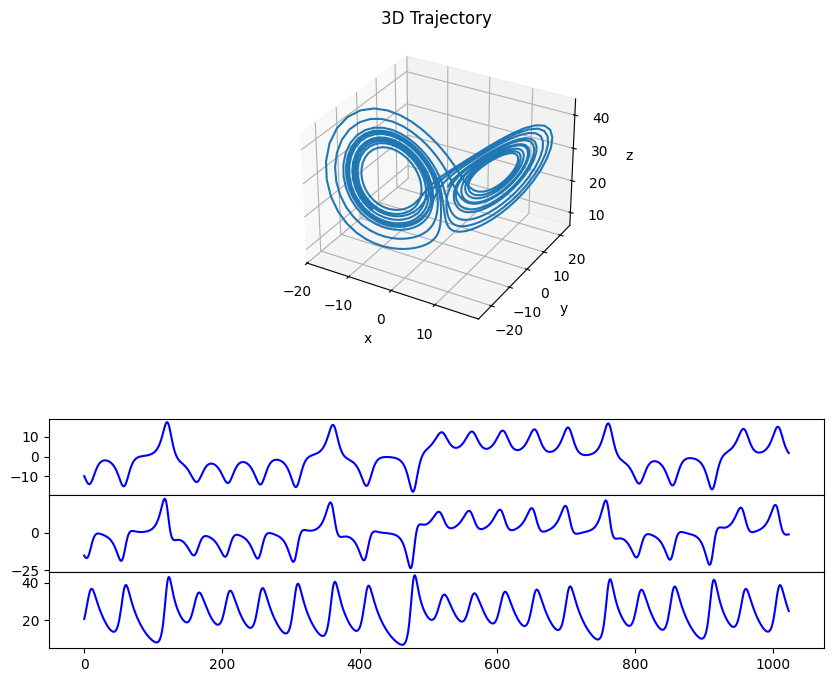

In [3]:
def plot_trajectory_with_coords(traj: np.ndarray, clip: float = None) -> None:
    """Plot 3D trajectory and individual coordinates.

    Args:
        traj: Trajectory array of shape (T, 3)
        clip: Optional float to clamp trajectory values between [-clip, clip]
    """
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 3], hspace=0.3)

    ax1 = fig.add_subplot(gs[0], projection="3d")
    ax1.plot(traj[:, 0], traj[:, 1], traj[:, 2])
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("z")
    ax1.set_title("3D Trajectory")

    # Bottom row - individual coordinates with shared x axis
    t = np.arange(len(traj))
    gs_bot = gs[1].subgridspec(3, 1, hspace=0)
    axes = []

    # For each coordinate, plot full range and clipped version if clip provided
    for i, (ax, label) in enumerate(
        [(gs_bot[0], "x"), (gs_bot[1], "y"), (gs_bot[2], "z")]
    ):
        ax_i = fig.add_subplot(ax, sharex=axes[0] if i > 0 and axes else None)
        axes.append(ax_i)
        coord = traj[:, i]
        ax_i.plot(t, coord, color="blue")


plot_trajectory_with_coords(traj)

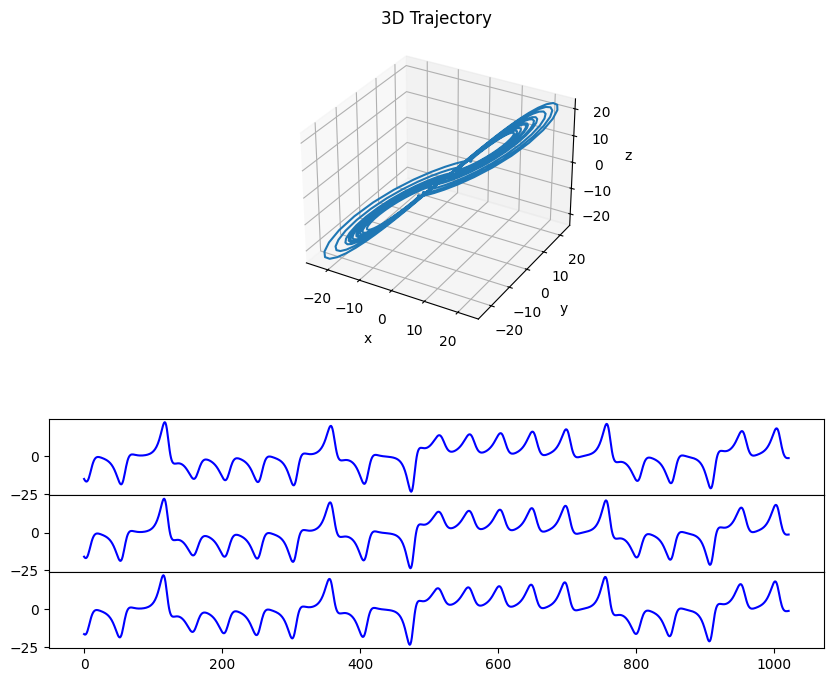

In [ ]:
def takens_reconstruction(signal: np.ndarray, dim: int, tau: int) -> np.ndarray:
    """Perform Takens time-delay embedding reconstruction.

    Args:
        signal: 1D time series of shape (T,)
        dim: Embedding dimension
        tau: Time delay/lag parameter

    Returns:
        Reconstructed trajectory array of shape (T-(dim-1)*tau, dim)
    """
    T = len(signal)
    N = T - (dim - 1) * tau  # Number of points in reconstruction

    # Create time-delayed copies
    reconstruction = np.zeros((N, dim))
    for i in range(dim):
        reconstruction[:, i] = signal[i * tau : i * tau + N]

    return reconstruction


coord = traj[:, 1]
reconstructed = takens_reconstruction(coord, 3, 1)
plot_trajectory_with_coords(reconstructed)


In [8]:
def animate_takens_reconstruction(x: np.ndarray, dim: int, max_tau: int = 20) -> None:
    """Animate Takens reconstruction with increasing time delay.

    Args:
        x: 1D signal array of shape (T,)
        dim: Embedding dimension
        max_tau: Maximum time delay to show
    """
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 3], hspace=0.3)

    ax3d = fig.add_subplot(gs[0], projection="3d")
    gs_bot = gs[1].subgridspec(3, 1, hspace=0)
    axes = [fig.add_subplot(gs_bot[i]) for i in range(3)]

    line_3d = ax3d.plot([], [], [], label="Reconstruction")[0]
    lines_coords = [ax.plot([], [], label="Reconstruction")[0] for ax in axes]

    # Pre-compute axis limits
    all_recons = [takens_reconstruction(x, dim, tau + 1) for tau in range(max_tau)]
    x_min = min(r[:, 0].min() for r in all_recons)
    x_max = max(r[:, 0].max() for r in all_recons)
    y_min = min(r[:, 1].min() for r in all_recons)
    y_max = max(r[:, 1].max() for r in all_recons)
    z_min = min(r[:, 2].min() for r in all_recons)
    z_max = max(r[:, 2].max() for r in all_recons)

    ax3d.set_xlim(x_min, x_max)
    ax3d.set_ylim(y_min, y_max)
    ax3d.set_zlim(z_min, z_max)

    # Set time axis limits for bottom plots
    t_max = len(x) - 2 * max_tau
    for ax in axes:
        ax.set_xlim(0, t_max)
        ax.set_ylim(min(x_min, y_min, z_min), max(x_max, y_max, z_max))

    def init():
        line_3d.set_data([], [])
        line_3d.set_3d_properties([])
        for line in lines_coords:
            line.set_data([], [])
        return [line_3d] + lines_coords

    def update(tau):
        recon = takens_reconstruction(x, dim, tau + 1)
        t = np.arange(len(recon))

        line_3d.set_data(recon[:, 0], recon[:, 1])
        line_3d.set_3d_properties(recon[:, 2])

        for i, line in enumerate(lines_coords):
            line.set_data(t, recon[:, i])

        ax3d.set_title(f"Takens Reconstruction (τ={tau + 1})")
        return [line_3d] + lines_coords

    # Set axis labels
    ax3d.set_xlabel("x(t)")
    ax3d.set_ylabel("x(t+τ)")
    ax3d.set_zlabel("x(t+2τ)")

    for i, ax in enumerate(axes):
        ax.set_ylabel(f"x(t+{i}τ)")
        if i < 2:
            ax.set_xticks([])
    axes[-1].set_xlabel("Time")

    from matplotlib.animation import FuncAnimation

    anim = FuncAnimation(
        fig, update, frames=max_tau, init_func=init, interval=200, blit=True
    )

    plt.close()
    return anim


# Create and display animation using z-coordinate
x = traj[:, 1]  # Use z coordinate
anim = animate_takens_reconstruction(x, dim=3)
from IPython.display import HTML

HTML(anim.to_jshtml())